In continuation from Notebook 1, the train and test data has to be redefined. To reduce time and space complexity, they can be loaded from the .npy files that were saved in Notebook 1.

# Import libraries

In [1]:
from sklearn import preprocessing
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.preprocessing import image # Module with image-preprocessing utilities
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19, ResNet101, ResNet152
from tensorflow.keras.callbacks import EarlyStopping

First and foremost, we load the csv files to ensure that we have the correct set of data.

In [2]:
train_df = pd.read_csv("train.csv",usecols=[1,2])
train_df

,image,label
0,fer2013/train/happy/Training_50449107.jpg,happy
1,fer2013/train/happy/Training_70433018.jpg,happy
2,fer2013/train/happy/Training_85610005.jpg,happy
3,fer2013/train/happy/Training_4460748.jpg,happy
4,fer2013/train/happy/Training_6312930.jpg,happy
...,...,...
28704,fer2013/train/disgust/Training_94788538.jpg,disgust
28705,fer2013/train/disgust/Training_81049148.jpg,disgust
28706,fer2013/train/disgust/Training_28365203.jpg,disgust
28707,fer2013/train/disgust/Training_39197750.jpg,disgust


In [3]:
test_df = pd.read_csv("test.csv",usecols=[1,2])
test_df

,image,label
0,fer2013/test/happy/PrivateTest_45699463.jpg,happy
1,fer2013/test/happy/PrivateTest_61855708.jpg,happy
2,fer2013/test/happy/PublicTest_53681781.jpg,happy
3,fer2013/test/happy/PrivateTest_52109800.jpg,happy
4,fer2013/test/happy/PublicTest_41104919.jpg,happy
...,...,...
7173,fer2013/test/disgust/PrivateTest_79683471.jpg,disgust
7174,fer2013/test/disgust/PrivateTest_34013087.jpg,disgust
7175,fer2013/test/disgust/PublicTest_67559665.jpg,disgust
7176,fer2013/test/disgust/PrivateTest_89077668.jpg,disgust


Then, we load the train and test data which contains 3 channels.

In [4]:
x_train_3 = np.load('x_train_data_3.npy')
print('x_train', x_train_3.shape)
x_test_3 = np.load('x_test_data_3.npy')
print('x_test', x_test_3.shape)

x_train (28709, 48, 48, 3)
x_test (7178, 48, 48, 3)


In [5]:
y_train = np.load('y_train_data.npy')
y_test = np.load('y_test_data.npy')

We apply train_test_split to the data accordingly.

In [6]:
partial_X_train_3, X_val_3, partial_y_train_3, y_val_3 = train_test_split(x_train_3, y_train, test_size=0.2, random_state=42)

In [7]:
print(partial_X_train_3.shape)
print(X_val_3.shape)
print(partial_y_train_3.shape)
print(y_val_3.shape)

(22967, 48, 48, 3)
(5742, 48, 48, 3)
(22967, 7)
(5742, 7)


Continuing from Notebook 2, transfer learning will be implemented.

# Transfer Learning

5 different pretrained convolutional neural networks (pCNNs): VGG16, VGG19, ResNet50V2, ResNet101 and ResNet152 were selected. The 5 are classification algorithms that classify 1000 images of 1000 different classes and were selected based on literature review, accuracy scores and popularity. The best performing one will be compared with all other models. pCNNs come with weights that were extensively trained on ImageNet, a large image database. Thus, for each of them, there will be at least 2 different models to train on, one where all layers are frozen and another where the top layer(s) will be unfrozen. Freezing all layers means the model is unable to train the parameters and prevents the weights from being updated during training. Unfreezing the top layer(s) trains the model to be more specific to the problem, which is recognizing emotions. Thus, we will experiment with the 5 different pCNNs.

## Define functions

First, we coordinate the 5 different pCNNs with an assigned number, as shown below:
- 1 - VGG16
- 2 - VGG19
- 3 - ResNet50V2
- 4 - ResNet101
- 5 - ResNet152

Since Model E is going to be transfer learning with data augmentation, we redefine the process as seen in the cells below.

In [10]:
# Setting up an image data augmentation configuration 
# using ImageDataGenerator which augments the images based on the features specified
train_imagegen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [12]:
# fit the image data generator to the training data
train_imagegen.fit(x_train_3)

# Generated batches of augmented data that are separated into partial and validation datasets. 
ptrain_image_generators = train_imagegen.flow(partial_X_train_3, partial_y_train_3)
val_image_generators = train_imagegen.flow(X_val_3, y_val_3)

In [13]:
# Define plotting of the accuracy graph for efficiency
def plot_graph(history):
    plt.plot(history['accuracy'], label="Train Accuracy") # blue 
    plt.plot(history['val_accuracy'], label="Validation Accuracy") # orange
    plt.legend()
    plt.title('Accuracy Graph')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.show()

Since there are 5 different pCNNs, it is more efficient to define a function to automate the process of training the model regardless of freezing the layers or not. A stop early function is first defined to optimize the process by stopping the training when the model stops improving and prevents overfitting. 

In [14]:
# Define a stop early function; stops training when validation accuracy stops improving for 5 epochs 
# then restore the weights
callback = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True,
    patience=5
)

Then, the function is put together. The model is built on top of the pCNN and a Flatten and the 3 Dense layers that were tuned were added. Explanation of the code is commented below.

In [34]:
"""
Hyperparameters:

untrainable - Boolean indicating trainable or untrainable; if True, classifier is untrainable and vice versa
ptrain_image_generators - ImageDataGenerator applied for partial training dataset
val_image_generators - ImageDataGenerator applied for validation dataset
callback - callback function(s)
trainable_layers - type list or str that contains layers to train (unfreeze); 
                   if type list, layer names contained in the list will be trainable
                   if type str, layers whose names contain the str will be trainable
"""
def call_classifier(untrainable, ptrain_image_generators, val_image_generators, callback, trainable_layers):
    # Prints out the list of pCNNs for the user to choose
    print("""1 - VGG16
    2 - VGG19
    3 - ResNet50V2
    4 - ResNet101
    5 - ResNet152
        """)
    # Asks user for their selection of pCNN
    num = int(input("Select a classifier by entering the number: "))
    # Define the convolutional base based on the number entered
    if num == 1: # VGG16
        conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(48, 48, 3))
    elif num == 2: # VGG19
        conv_base = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(48, 48, 3))
    elif num == 3: # ResNet50V2
        conv_base = ResNet50V2(weights='imagenet',
                          include_top=False,
                          input_shape=(48, 48, 3))
    elif num == 4: # ResNet101
        conv_base = ResNet101(weights='imagenet',
                        include_top=False,
                        input_shape=(48, 48, 3))
    elif num == 5: # ResNet152
        conv_base = ResNet152(weights='imagenet',
                            include_top=False,
                            input_shape=(48, 48, 3))
    else: 
        return print("Something wrong")

    # Build model on top of the convolutional base
    model = models.Sequential()
    model.add(conv_base)
    model.add(Flatten())
    # fully connected layers
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00008)))
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.00002)))
    # output layer
    model.add(Dense(7, activation='softmax'))
    print("Model Summary")
    print(model.summary())

    if untrainable: # Freeze all layers
        # Ensures the correct situation is called
        print("Untrainable mode")
        # Dont want to train what is alr been trained
        conv_base.trainable = False
    else: # Unfreeze specified layers
        # Ensures the correct situation is called
        print("Trainable mode")
        # Set trainable for all layers to be True 
        conv_base.trainable = True
        # Define a boolean for changing the trainable feature
        set_trainable = False
        # For each layer in conv_base
        for layer in conv_base.layers:
            if type(trainable_layers) == list:
                # If any of the layer's names coincide with any in the unfreeze list
                if layer.name in trainable_layers:
                    # Change the boolean variable to True
                    set_trainable = True
            elif type(trainable_layers) == str:
                # if the str trainable_layers is contained in the layer's name
                if trainable_layers in layer.name:
                    # Change the boolean variable to True
                    set_trainable = True
          # Depending on the boolean
            if set_trainable:
                # If True, set the layer to be trainable
                layer.trainable = True
                # Making sure we have captured the correct layers
                print('unfreeze', layer.name)
            else:
                # If False, set the layer to be untrainable
                layer.trainable = False
                # Making sure we have captured the correct layers
                print('freeze', layer.name)

    tf.random.set_seed(42)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    print("Start model.fit")
    # fits the model on the predefined batches with real-time data augmentation
    history = model.fit(ptrain_image_generators,
                      validation_data=val_image_generators,
                      epochs=100, batch_size=64, callbacks=[callback])
    return history, model

To know what layers each of the pCNNs carry, the following cell is executed to show the model architecture of each of the pCNNs.

## Layers in Classifiers

In [22]:
vgg16 = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(48, 48, 3))
print('VGG16'+'\n')
vgg16.summary()
  
vgg19 = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(48, 48, 3))
print('VGG19'+'\n')
vgg19.summary()

rn50v2 = ResNet50V2(weights='imagenet',
                          include_top=False,
                          input_shape=(48, 48, 3))
print('ResNet50V2'+'\n')
rn50v2.summary()

rn101 = ResNet101(weights='imagenet',
                          include_top=False,
                          input_shape=(48, 48, 3))
print('ResNet101'+'\n')
rn101.summary()

rn152 = ResNet152(weights='imagenet',
                          include_top=False,
                          input_shape=(48, 48, 3))
print('ResNet152'+'\n')
rn152.summary()

VGG16

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)      

After knowing what the layer names are for each of the pCNN, we can proceed with training the pCNNs on our data.

### VGG16 - Untrainable

Freezing the layers of the convolutional base means that its parameters are untrainable. Thus, only the classification layers, the last 3 Dense layers are trainable to model after our data. Since it is untrainable, the input parameter trainable_layers can be an empty list to feed into the function when called. Since the history and model are returned, we define variables to store this information.

In [24]:
trainable_layers = []
history, model = call_classifier(True, ptrain_image_generators, val_image_generators, callback, trainable_layers)

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - Xception
5 - InceptionV3
6 - InceptionResNetV2
        
Select a classifier by entering the number: 1
Model Summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Train

Using the history returned, we can call plot_graph to plot the training and validation accuracies.

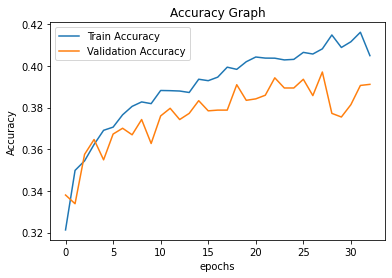

In [25]:
plot_graph(history.history)

The model is saved, then loaded and prints out the summary to ensure that it is saved accurately.

In [26]:
model.save('vgg16_untrainable.h5')
model = load_model('vgg16_untrainable.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Trainable params: 395,783
Non-trainable params: 14,714,688
_________________________________________________________________


It is then used to evaluate the test dataset.

In [27]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 4s 15ms/step - loss: 1.5472 - accuracy: 0.4154


The first pCNN VGG16 whose layers were frozen achieved a 40% train accuracy and 41% test accuracy. We then proceed with unfreezing and training VGG16's last convolutional block. 

### VGG16 - Trainable (Block 5)
Since we know the names of the layers of VGG16, we can list them out in the trainable_layers list. This time, the input parameter untrainable will be set to False.

In [29]:
trainable_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, trainable_layers)

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - Xception
5 - InceptionV3
6 - InceptionResNetV2
        
Select a classifier by entering the number: 1
Model Summary

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Train

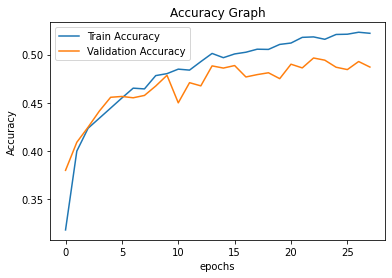

In [30]:
plot_graph(history.history)

We save the model and load it, as per the usual as VGG16 - Untrainable.

In [31]:
model.save('vgg16_trainable.h5')
model = load_model('vgg16_trainable.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Trainable params: 7,475,207
Non-trainable params: 7,635,264
_________________________________________________________________


In [32]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 3s 14ms/step - loss: 1.2375 - accuracy: 0.5316


For VGG16 whose layers were frozen except the last convolutional block achieved a 52% train accuracy and 53% test accuracy. We can conclude that for VGG16, unfreezing layers improves the model's performance in accuracy. 
We can then try experimenting with unfreezing another convolutional block. 

### VGG16 -  Trainable (Blocks 4 and 5) 
Now, we try unfreezing VGG16's convolutional blocks 4 and 5 by adding the layer names to the list.

In [33]:
trainable_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool']
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, trainable_layers)

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - Xception
5 - InceptionV3
6 - InceptionResNetV2
        
Select a classifier by entering the number: 1
Model Summary

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Train

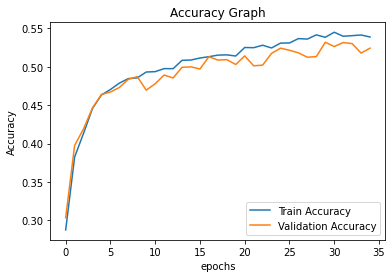

In [34]:
plot_graph(history.history)

In [35]:
model.save('vgg16_trainable_45.h5')
model = load_model('vgg16_trainable_45.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Trainable params: 13,374,983
Non-trainable params: 1,735,488
_________________________________________________________________


In [36]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 3s 14ms/step - loss: 1.2050 - accuracy: 0.5517


Freezing VGG16's convolutional blocks 4 and 5 achieved a 52% train accuracy and 53% test accuracy. We can conclude that for VGG16, unfreezing layers improves the model's performance in accuracy. 
We can then try experimenting with unfreezing the next convolutional block. 

### VGG16 -  Trainable (Blocks 3, 4 and 5)

In [37]:
trainable_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool']
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, trainable_layers)

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - Xception
5 - InceptionV3
6 - InceptionResNetV2
        
Select a classifier by entering the number: 1
Model Summary

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Train

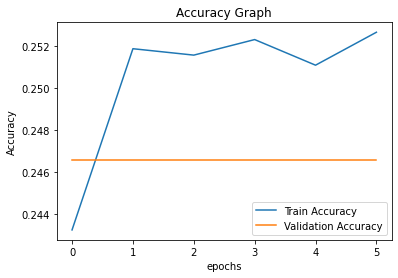

In [38]:
plot_graph(history.history)

In [39]:
model.save('vgg16_trainable_345.h5')
model = load_model('vgg16_trainable_345.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 15,110,471
Trainable params: 14,850,311
Non-trainable params: 260,160
_________________________________________________________________


In [40]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 3s 14ms/step - loss: 1.8372 - accuracy: 0.2471


Freezing the next convolutional block achieved a 25% train accuracy and 24% test accuracy. We can conclude that for our data, in regards to VGG16, freezing the fourth convolutional block is the maximum. Unfreezing more layers would worsen the model's performance, possibly due to the learning speed. The more layers there are, the slower the learning speed at each layer, as it is getting further from the output layer. The learning rate will thus be slower in the earlier layers. 
Then, we go through the same process for the rest of the pCNNs. 

### VGG19 - Untrainable

In [41]:
history, model = call_classifier(True, ptrain_image_generators, val_image_generators, callback, [])

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - Xception
5 - InceptionV3
6 - InceptionResNetV2
        
Select a classifier by entering the number: 2
80150528/80134624 [==============================] - 1s 0us/step
Model Summary

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 7)                 1799      
                               

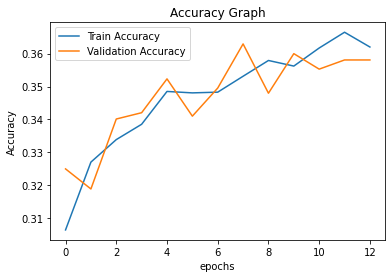

In [42]:
plot_graph(history.history)

In [43]:
model.save('vgg19_untrainable.h5')
model = load_model('vgg19_untrainable.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 20,420,167
Trainable params: 395,783
Non-trainable params: 20,024,384
_________________________________________________________________


In [44]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 4s 16ms/step - loss: 1.5890 - accuracy: 0.3780


### VGG19 - Trainable (Block 5)

In [45]:
trainable_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, trainable_layers)

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - Xception
5 - InceptionV3
6 - InceptionResNetV2
        
Select a classifier by entering the number: 2
Model Summary

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 20,420,167
Train

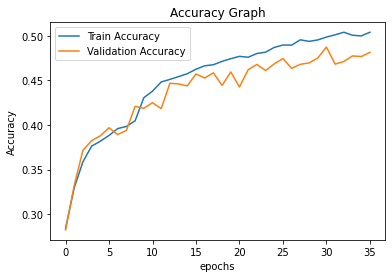

In [46]:
plot_graph(history.history)

In [47]:
model.save('vgg19_trainable5.h5')
model = load_model('vgg19_trainable5.h5')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 20,420,167
Trainable params: 9,835,015
Non-trainable params: 10,585,152
_________________________________________________________________


In [48]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 4s 16ms/step - loss: 1.2963 - accuracy: 0.5093


### VGG19 - Trainable (Blocks 4 and 5)

In [49]:
trainable_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool']
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, trainable_layers)

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - Xception
5 - InceptionV3
6 - InceptionResNetV2
        
Select a classifier by entering the number: 2
Model Summary

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 20,420,167
Train

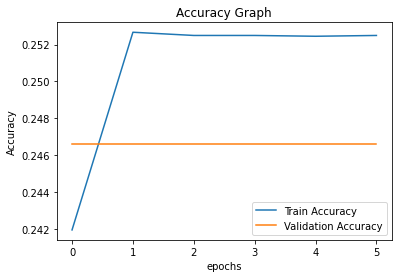

In [50]:
plot_graph(history.history)

In [51]:
model.save('vgg19_trainable45.h5')
model = load_model('vgg19_trainable45.h5')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 20,420,167
Trainable params: 18,094,599
Non-trainable params: 2,325,568
_________________________________________________________________


In [52]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 4s 17ms/step - loss: 1.8279 - accuracy: 0.2471


### ResNet50V2 - Untrainable

In [24]:
history, model = call_classifier(True, ptrain_image_generators, val_image_generators, callback, [])

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - ResNet101
5 - ResNet152
        
Select a classifier by entering the number: 3
Model Summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 27,892,743
Trainable params: 27,847,303
N

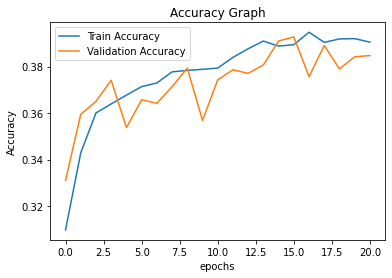

In [25]:
plot_graph(history.history)

In [26]:
model.save('rn50v2_untrainable.h5')
model = load_model('rn50v2_untrainable.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 27,892,743
Trainable params: 4,327,943
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 5s 17ms/step - loss: 1.5665 - accuracy: 0.4042


### ResNet50V2 - Trainable (Conv 5 Block 3)

In [31]:
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, 'conv5_block3')

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - ResNet101
5 - ResNet152
        
Select a classifier by entering the number: 3
Model Summary

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               4194816   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 27,892,743
Trainable params: 27,847,303

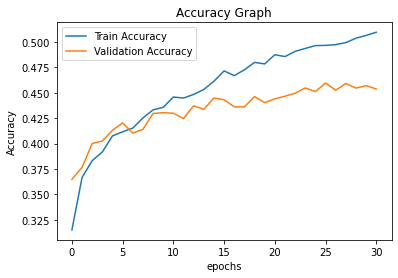

In [32]:
plot_graph(history.history)

In [33]:
model.save('rn50v2_trainable53.h5')
model = load_model('rn50v2_trainable53.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               4194816   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 27,892,743
Trainable params: 8,796,679
Non-trainable params: 19,096,064
_________________________________________________________________


In [34]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 5s 16ms/step - loss: 1.3754 - accuracy: 0.4905


### ResNet101 - Untrainable

In [35]:
history, model = call_classifier(True, ptrain_image_generators, val_image_generators, callback, [])

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - ResNet101
5 - ResNet152
        
Select a classifier by entering the number: 4
Model Summary

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2, 2, 2048)        42658176  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               4194816   
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 46,986,119
Trainable params: 46,880,775

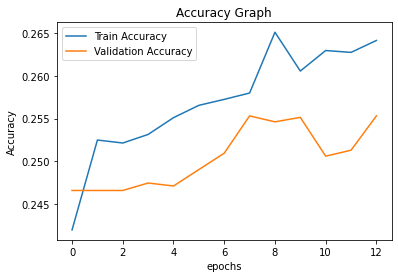

In [36]:
plot_graph(history.history)

In [37]:
model.save('rn101_untrainable.h5')
model = load_model('rn101_untrainable.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2, 2, 2048)        42658176  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               4194816   
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 46,986,119
Trainable params: 4,327,943
Non-trainable params: 42,658,176
_________________________________________________________________


In [38]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 9s 30ms/step - loss: 1.7750 - accuracy: 0.2733


### ResNet101 - Trainable (Conv 5 Block 3)

In [39]:
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, 'conv5_block3')

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - ResNet101
5 - ResNet152
        
Select a classifier by entering the number: 4
Model Summary

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2, 2, 2048)        42658176  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 46,986,119
Trainable params: 46,880,775

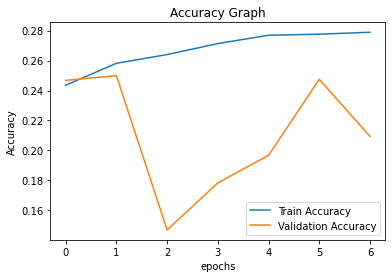

In [40]:
plot_graph(history.history)

In [41]:
model.save('rn101_trainable53.h5')
model = load_model('rn101_trainable53.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2, 2, 2048)        42658176  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 46,986,119
Trainable params: 8,793,607
Non-trainable params: 38,192,512
_________________________________________________________________


In [42]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 9s 31ms/step - loss: 1.7840 - accuracy: 0.2643


### ResNet152 - Untrainable

In [43]:
history, model = call_classifier(True, ptrain_image_generators, val_image_generators, callback, [])

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - ResNet101
5 - ResNet152
        
Select a classifier by entering the number: 5
Model Summary

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               4194816   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 62,698,887
Trainable params: 62,547,463

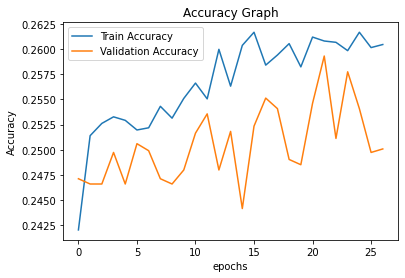

In [44]:
plot_graph(history.history)

In [45]:
model.save('rn152_untrainable.h5')
model = load_model('rn152_untrainable.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               4194816   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 62,698,887
Trainable params: 4,327,943
Non-trainable params: 58,370,944
_________________________________________________________________


In [46]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 12s 41ms/step - loss: 1.7645 - accuracy: 0.2699


### ResNet152 - Trainable (Conv 5 Block 3)

In [47]:
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, 'conv5_block3')

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - ResNet101
5 - ResNet152
        
Select a classifier by entering the number: 5
Model Summary

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               4194816   
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 62,698,887
Trainable params: 62,547,463

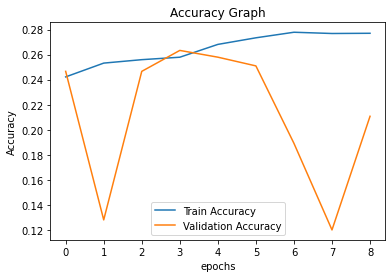

In [48]:
plot_graph(history.history)

In [49]:
model.save('rn152_trainable53.h5')
model = load_model('rn152_trainable53.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               4194816   
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 62,698,887
Trainable params: 8,793,607
Non-trainable params: 53,905,280
_________________________________________________________________


In [50]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 11s 39ms/step - loss: 1.7627 - accuracy: 0.2771


### ResNet152 - Trainable (Conv 5)
Just to see what happens if we train one whole convolution, we can unfreeze the whole of conv 5.

In [51]:
history, model = call_classifier(False, ptrain_image_generators, val_image_generators, callback, 'conv5_block')

1 - VGG16
2 - VGG19
3 - ResNet50V2
4 - ResNet101
5 - ResNet152
        
Select a classifier by entering the number: 5
Model Summary

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               4194816   
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 62,698,887
Trainable params: 62,547,463

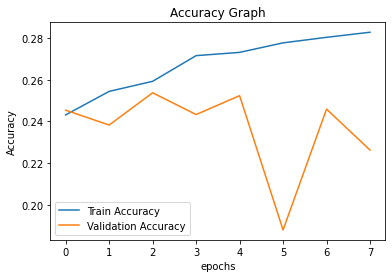

In [52]:
plot_graph(history.history)

In [53]:
model.save('rn152_trainable5.h5')
model = load_model('rn152_trainable5.h5')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               4194816   
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 62,698,887
Trainable params: 19,303,943
Non-trainable params: 43,394,944
_________________________________________________________________


In [54]:
test_loss, test_acc = model.evaluate(x_test_3, y_test)

225/225 [==============================] - 12s 40ms/step - loss: 1.7930 - accuracy: 0.2579


From the results above, we can summarise them as such:

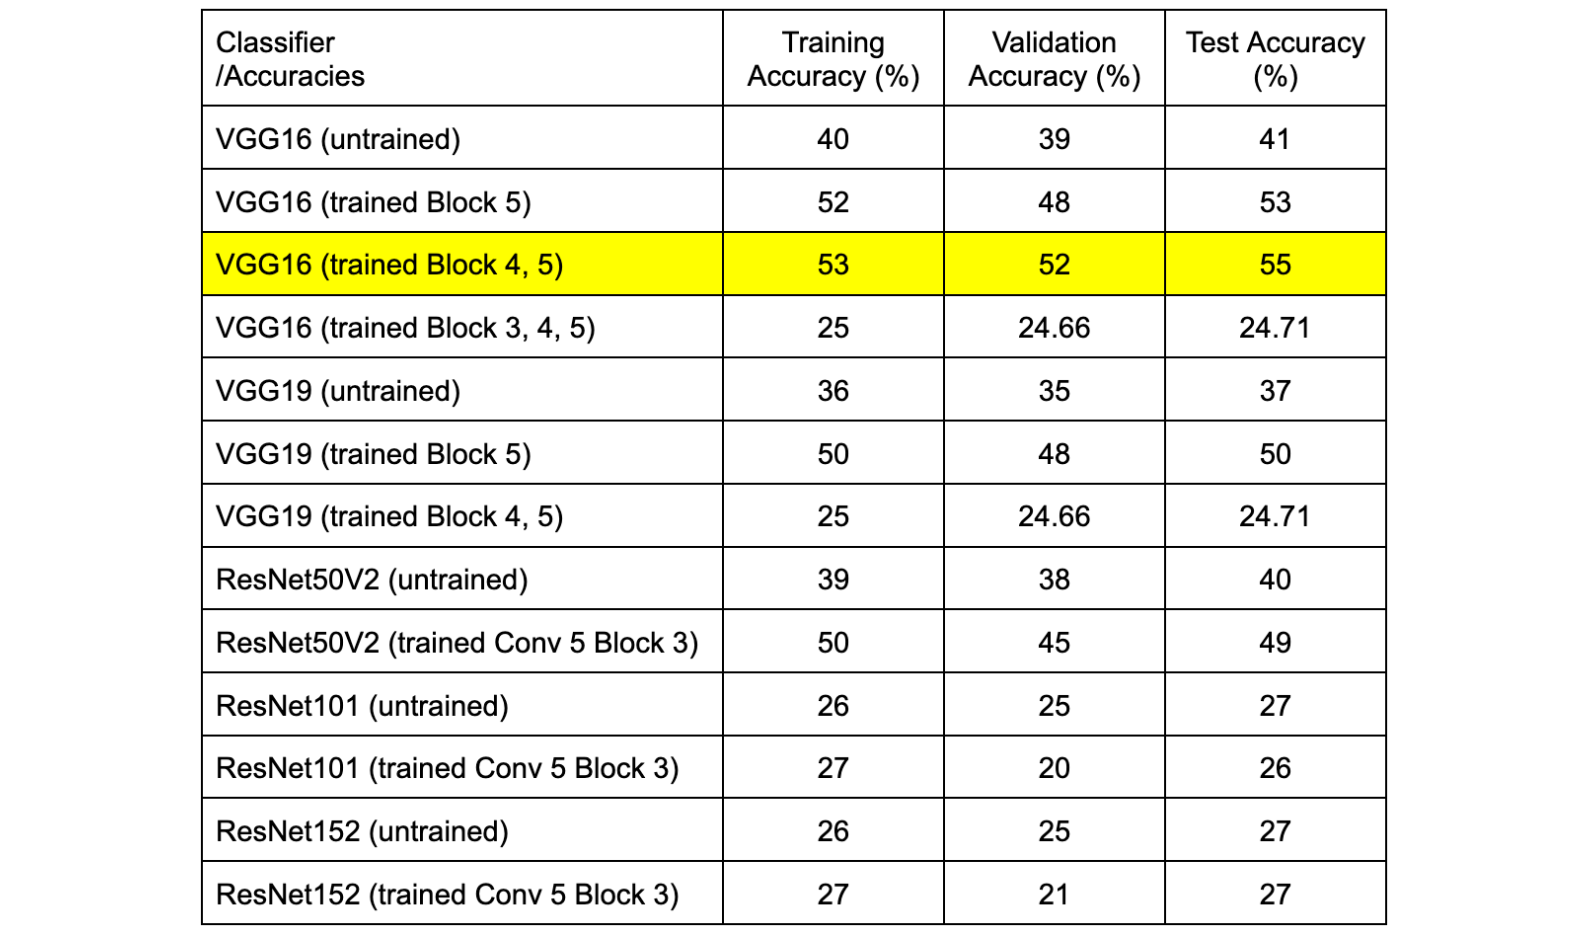

From the table above, we can conclude that as the convnets contain more layers and thus more parameters, the worse the accuracy and performance. This may be due to the dataset being unsuitable for deeper neural networks, as evident from the different ResNets. We can see that the winning classifier is VGG16, whose Blocks 4 and 5 were trainable. Unfreezing more layers and achieving a higher accuracy may be possible if there is large training data. The higher the number of trainable parameters, the higher the risk of overfitting, especially on a small dataset.

# Live Demonstration
The codes for live demonstration is adapted from Deep Learning with Python (Chollet, 2018)

We first define the LabelEncoder for our 7 classes of facial expressions.

In [13]:
# Instantiate LabelEncoder
le = preprocessing.LabelEncoder()
# Pass in our train_label list which contains the labels for the images to generate a list of unique emotions
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
le.fit(labels)
list(le.classes_)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Then, we define the two best models below, Models D and E, the model with data augmentation and the model that incorporates transfer learning of VGG16 respectively, to compare their prediction on the same image.

Truth Label: angry
Model D Predicted Label: neutral
Model E Predicted Label: neutral


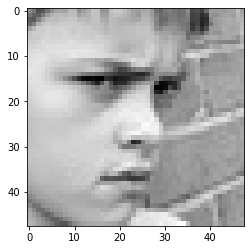

In [32]:
# generates a random number 
random_number = random.randint(0, len(test_df))
# Chooses one random image from test dataset 
print("Truth Label:", test_df['label'][random_number])

model_D = load_model('data_aug.h5')
model_E = load_model('vgg16_trainable_45.h5')

img_path = test_df['image'][random_number]

img = image.load_img(img_path, color_mode="grayscale") # Reads the image for 1 channel
img_3 = image.load_img(img_path) # Reads the image for 3 channels

x = image.img_to_array(img) # Converts to a Numpy array with shape (48, 48, 1)
x = x.reshape((1,) + x.shape) # Reshapes it to (1, 48, 48, 1)

x_3 = image.img_to_array(img_3) # Converts to a Numpy array with shape (48, 48, 3)
x_3 = x_3.reshape((1,) + x_3.shape) # Reshapes it to (1, 48, 48, 3)

model_D_pred = model_D.predict(x, verbose = 0)
model_D_pred_label = le.inverse_transform([model_D_pred.argmax()])[0]
print("Model D Predicted Label:", model_D_pred_label)
model_E_pred = model_E.predict(x_3, verbose = 0)
model_E_pred_label = le.inverse_transform([model_E_pred.argmax()])[0]
print("Model E Predicted Label:", model_E_pred_label)

plt.imshow(x.reshape(48, 48), cmap='gray')

# References

1. (Chollet, 2018)

Chollet, F., 2018. Deep Learning with Python. USA: Manning Publications Co., p.139-140.